In [1]:
import pandas as pd
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gaurav.gupta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
#!pip install ftfy
#!pip install scrubadub
#!pip install demoji
#!pip install tabulate
#!pip install wordcloud

In [2]:
def read_file():
    df = pd.read_csv(
        '/home/gaurav.gupta/projects/PoCs/brandMention/brand_datasets/ds_complaints/panasonic_v1_g.csv')
    df = df[['text', 'Complaint']]
    return df
    #df.head(2)

In [3]:
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
import re
import ftfy
import scrubadub
# import string
from tabulate import tabulate
import demoji
# import emoji
from nltk.corpus import stopwords


stop = stopwords.words('english')
emailDetector = scrubadub.Scrubber(detector_list=[scrubadub.detectors.EmailDetector])
wnl = WordNetLemmatizer()

label_codes = {'No': 0, 'Yes': 1}
t_handle_regex = r'(^|[^@\w])@(\w{1,15})\b'
t_hashtag_regex = r"#(\w+)"
t_url_regex = r"https?://\S+|www\.\S+"
t_markup_regex = r"<(\"[^\"]*\"|'[^']*'|[^'\">])*>"
t_handle_placeholder = ' {{HANDLE}}'
t_hashtag_placeholder = ' {{HASHTAG}}'
t_url_placeholder = '{{URL}}'
t_markup_placeholder = '{{MARKUP}}'
emoji_placeholder = '{{EMOJI}}'
# domain specific stopwords.
stop.extend(['panasonic'])

# table = str.maketrans("", "")


def penn_to_wn(tag):
    def is_noun(tag):
        return tag in ['NN', 'NNS', 'NNP', 'NNPS']

    def is_verb(tag):
        return tag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']

    def is_adverb(tag):
        return tag in ['RB', 'RBR', 'RBS']

    def is_adjective(tag):
        return tag in ['JJ', 'JJR', 'JJS']

    # Pos tags to wn tags
    if is_adjective(tag):
        return wn.ADJ
    elif is_noun(tag):
        return wn.NOUN
    elif is_adverb(tag):
        return wn.ADV
    elif is_verb(tag):
        return wn.VERB
    return None

def to_lower_case(text):
    return text.lower()

def fix_unicode(text):
    return ftfy.fix_text(text)

def replace_email(text):
    return emailDetector.clean(text)

def remove_stop_words(text):
    return ' '.join([word for word in text.split() if word not in (stop)])

def convert_emoji_to_text(text):
    return text

def replace_user_name(text):
    return re.sub(t_handle_regex, t_handle_placeholder, text)

def replace_hashtags(text):
    return re.sub(t_hashtag_regex, t_hashtag_placeholder,text)

def replace_url(text):
    return re.sub(t_url_regex, t_url_placeholder, text)

def replace_markup(text):
    return re.sub(t_markup_regex, t_markup_placeholder,text)

def remove_punctuations(text):
    return re.sub(r'[^\w\s]', '', text)

def replace_emoji_with_code(text):
    demoji.replace(text, repl=emoji_placeholder)
    return demoji.replace_with_desc(text)

def get_stats(step, df):
    corpus = " ".join(list(df['text']))
    total_words = len(corpus.split(' '))
    unique_words = len(set(corpus.split(' ')))
    return [step, total_words, unique_words]

def lemmatize(text):
    default_wn_tag = 'n'
    tokens = text.split(' ')
    pos_tags = nltk.pos_tag(tokens)
    wn_tags = [penn_to_wn(tag) for (w, tag) in pos_tags]
    # print(list(zip(pos_tags, wn_tags)))
    lemmas = [wnl.lemmatize(token, tag or default_wn_tag) for (token, tag) in list(zip(tokens, wn_tags))]
    return ' '.join(lemmas)


def process_data(df):
    stats = [['Step', 'Total words', 'Unique words']]
    stats.append(get_stats('Start', df))
    df = df.replace(label_codes)
    df['orig_text'] = df['text']

    df['text'] = df['text'].apply(lambda text: text.lower())
    stats.append(get_stats('Lower', df))

    df['text'] = df['text'].apply(lambda text: lemmatize(text))
    stats.append(get_stats('Lemmatize', df))

    df['text'] = df['text'].apply(fix_unicode)
    stats.append(get_stats('Unicode Fix', df))

    df['text'] = df['text'].apply(replace_emoji_with_code)
    stats.append(get_stats('Replace emoji', df))

    df['text'] = df['text'].apply(remove_stop_words)
    stats.append(get_stats('Stop words', df))

    df['text'] = df['text'].apply(replace_email)
    stats.append(get_stats('Email Replace', df))

    df['text'] = df['text'].apply(replace_user_name)
    stats.append(get_stats('UserName replace', df))

    df['text'] = df['text'].apply(replace_hashtags)
    stats.append(get_stats('HashTags Replace', df))

    df['text'] = df['text'].apply(replace_url)
    stats.append(get_stats('URL Replace', df))

    df['text'] = df['text'].apply(replace_markup)
    stats.append(get_stats('MARKUP Replace', df))

    df['text'] = df['text'].apply(remove_punctuations)
    stats.append(get_stats('Remove punctuation', df))

    print(tabulate(stats))
    return df


df = read_file()
df['orig_text'] = df['text']
df = process_data(df)


------------------  -----------  ------------
Step                Total words  Unique words
Start               50105        13092
Lower               50105        11752
Lemmatize           50105        11159
Unicode Fix         50094        11124
Replace emoji       50279        11157
Stop words          36490        10611
Email Replace       36490        10609
UserName replace    37125        9762
HashTags Replace    46119        7497
URL Replace         46119        6240
MARKUP Replace      46119        6240
Remove punctuation  46119        5019
------------------  -----------  ------------


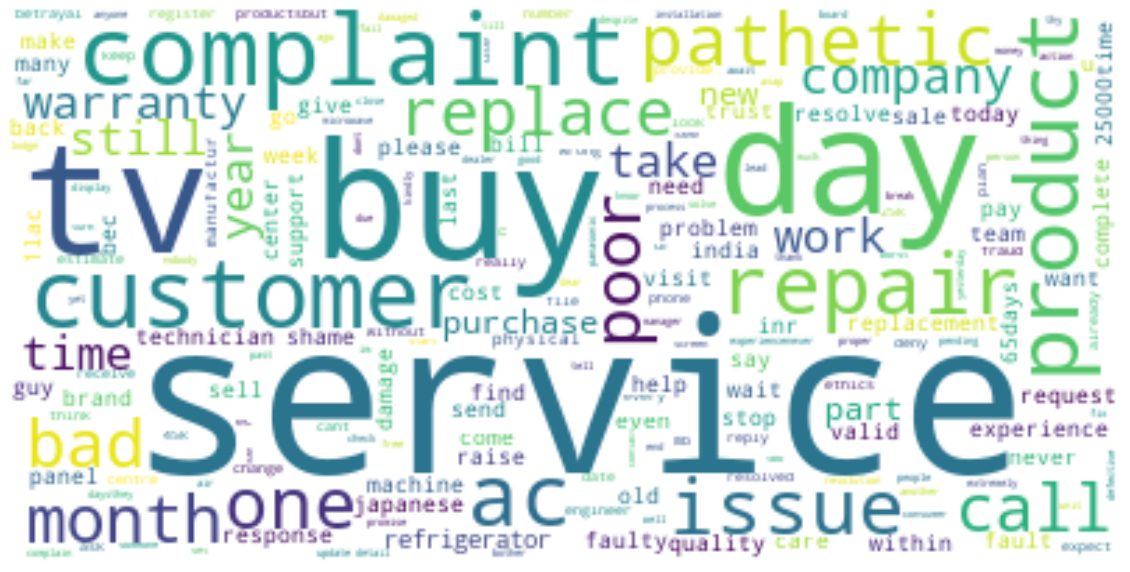

In [4]:
#Importing Libraries
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20, 16))
# corpus = " ".join(list(df['text']))
corpus = " ".join(list(df[df['Complaint'] == 1]['text']))

word_cloud = WordCloud(collocations=False, background_color='white').generate(
    corpus.replace('HASHTAG', '').replace('HANDLE', '').replace('URL', ''))

plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.naive_bayes import BernoulliNB

''' 
2.  Vectorize the text using Tfidfvectorizer  [DONE]
1.  Split data into training, validation and test set.
3.  Use any classification model for prediction. [binary-classification]
4.  Evaluate the model on test data.
'''

tfidf = TfidfVectorizer(lowercase=False, max_df=.8, min_df=0.01)  # 2
tfidf_wm = tfidf.fit_transform(df['text']).toarray() #2
x_train, x_test, y_train, y_test = train_test_split(tfidf_wm, df['Complaint']) #1

# train model and print validation score.
model = BernoulliNB().fit(x_train, y_train)
pred_train = model.predict(x_train)
acc_score_train = accuracy_score(y_train, pred_train)
print('Training-set accuracy score: {0:0.4f}'. format(acc_score_train))

# evaluate on test data and print testing score.
pred_test = model.predict(x_test)
acc_score_test = accuracy_score(y_test, pred_test)
print('Testing-set accuracy score: {0:0.4f}'. format(acc_score_test))

# print confusion matrix.
c_matrix = confusion_matrix(y_test, pred_test)
print('Confusion matrix\n\n', c_matrix)


Training-set accuracy score: 0.9044
Testing-set accuracy score: 0.9053
Confusion matrix

 [[286  32]
 [  7  87]]


In [6]:
r_df = pd.read_json('/home/gaurav.gupta/projects/PoCs/brandMention/brand_datasets/ds_complaints/panasonic_random_sample.json', lines=True)
pr_df = process_data(r_df)
pr_tfidf_wm = tfidf.transform(pr_df['text']).toarray()
pr_pred_test = model.predict(pr_tfidf_wm)
pr_df['predicted'] = pr_pred_test
pr_df.head(10)


------------------  -----------  ------------
Step                Total words  Unique words
Start               27579        9445
Lower               27579        8619
Lemmatize           27579        8283
Unicode Fix         27597        8281
Replace emoji       27865        8375
Stop words          22855        8323
Email Replace       22855        8319
UserName replace    22909        7771
HashTags Replace    29066        5426
URL Replace         29066        4478
MARKUP Replace      29066        4478
Remove punctuation  29066        3729
------------------  -----------  ------------


,text,created_at,orig_text,predicted
0,film HASHTAG URL special HASHTAG foil adapte...,{'$date': '2021-03-28T06:54:37.000+0000'},HOW TO FILM THE #SUN? https://t.co/YOnrP9bur7 ...,0
1,HANDLE centre awesome collection HANDLE plush...,{'$date': '2019-03-18T15:30:52.000+0000'},@BardillsGarden centre has an awesome collecti...,0
2,rt HANDLE HASHTAG contest 20 winner stand cha...,{'$date': '2021-10-28T09:36:55.000+0000'},RT @PanasonicIndia: #DecodeTheLingo Contest \...,0
3,rt HANDLE phoenix west bw HASHTAG HASHTAG H...,{'$date': '2019-07-14T21:58:31.000+0000'},RT @Negeos1: Phoenix West in B&amp;W #22photos...,0
4,rt HANDLE take part HASHTAG alongside HANDLE ...,{'$date': '2020-10-07T08:27:44.000+0000'},RT @Poorvika_Mobile: Take part in the #Poorvik...,0
5,film HASHTAG URL special HASHTAG foil adapte...,{'$date': '2021-02-17T20:47:47.000+0000'},HOW TO FILM THE #SUN? https://t.co/YOnrP9bur7 ...,0
6,long exposure smiling face sunglasses HASHTAG...,{'$date': '2018-07-07T01:43:39.000+0000'},Long exposures 😎\n#Panasonic #lumix\n#formatth...,0
7,HASHTAG p99 5inch display 4g volta launch rs ...,{'$date': '2017-09-28T14:50:36.000+0000'},"#Panasonic P99 with 5-inch display, 4G VoLTE l...",0
8,reposting HANDLEherbmedia snowcapped mountainb...,{'$date': '2018-03-15T20:28:08.000+0000'},Reposting @nordisch.herb.media:\n🏔🎈 Milford So...,0
9,vote HANDLE proud woman india plzzzz guy HASH...,{'$date': '2018-11-19T18:22:31.000+0000'},Vote for @ms_dipika the proud women of india p...,0
